In [2]:
## We'll be doing this from scratch, so all imports will come from 
## the Python standard library or 3rd-party tools
import socket
import struct
import base64
import json
import hashlib
import time
import enum
import xml.etree.ElementTree as ET
from enum import Enum

import pandas as pd
import password_obfuscation as obf

# iRODS Protocol Cookbook

This notebook will provide example implementations of key 
operations in the iRODS protocol. Read from the beginnging or use this table of contents to skip to the section that interests you. Once you've jumped to that spot, make sure the cell with the anchor is selected and run `Cell > Run All Above`.

## Table of Contents

* [Handshake](#handshake)
* [Authentication](#authentication)
* [ils](#ils)
    - [Stat a collection](#stat_coll)
    - [Querying for the Data Objects in a Container](#data_objects_query)
* [Data transfer](#data_transfer)
* [Streaming](#streaming)
* [Admin](#admin)
* [Rule Exec](#rule_exec)
* [Changing Your Password](#ipasswd)
* [Disconnect](#disconnect)
* [Appendix: iRODS Protocol Gotchas](#gotchas)

This tutorial assumes you have deployed iRODS in Docker using
the script stand_it_up.py from the iRODS Testing Environment, 
which can be found on Github [here](https://github.com/irods/irods_testing_environment)
To find the IP address associated with your Docker container, you can run this one-liner:
```bash
docker inspect -f '{{range.NetworkSettings.Networks}}{{.IPAddress}}{{end}}' ubuntu-2004-postgres-1012_irods-catalog-provider_1
```

*However,* this notebook works just fine for any iRODS deployment. Simply change the values `HOST`, `RODS_USER`, `PASSWORD`. It is recommended to create a new rodsadmin account or use an account whose password you are comfortable changing, and to start in the home collection of that user.

In [3]:
HOST = "172.27.0.3"
RODS_USER = "rods"
PASSWORD = "rods"

In [4]:
PORT = 1247 ## This is the standard iRODS port
MAX_PASSWORD_LENGTH = 50 ## This constant comes 
                         ## from the internals 
                         ## of the iRODS server
API_TABLE = {
    "AUTHENTICATION_APN":110000, ## The API number for the 4.3.0 auth framework
    "OBJ_STAT_AN":633,
    "GEN_QUERY_AN":702,
    "DATA_OBJ_PUT_AN": 606,
    "DATA_OBJ_OPEN_AN": 602,
    "DATA_OBJ_LSEEK_AN": 674,
    "DATA_OBJ_CLOSE_AN": 673,
    "DATA_OBJ_READ_AN": 675,
    "GENERAL_ADMIN_AN": 701,
    "EXEC_MY_RULE_AN": 625,
    "USER_ADMIN_AN": 714
}

## These provide indices into the catalog,
## which allows the i RODS server to directly query the SQL server
CATALOG_INDEX_TABLE = {
    "COL_COLL_NAME"       :"501",
    "COL_D_DATA_ID"       :"401",
    "COL_DATA_NAME"       :"403",
    "COL_COLL_INHERITANCE":"506",
    "COL_DATA_MODE"       :"421",
    "COL_DATA_SIZE"       :"407",
    "COL_D_MODIFY_TIME"   :"420",
    "COL_D_CREATE_TIME"   :"419"
}
CATALOG_REVERSE_INDEX_TABLE = {
    v:k for k,v in CATALOG_INDEX_TABLE.items()
}

## This is an arbitrary string hardcoded into the server; will be checked by the server
RANDOM_STRING_CLIENT_SIDE = "1gCBizHWbwIYyWLoysGzTe6SyzqFKMniZX05faZHWAwQKXf6Fs"
test_value = obf.encode(RANDOM_STRING_CLIENT_SIDE)

First, we're going to write a small library of functions that do some 
of the dirty work. 
Feel free to skip to [here](#start_of_real_work), where we start using this library to send
and read messages, referring to this part to figure out how
the part you're interested in was implemented. 

*Notice* that the comment above `def header(...` includes the packing instruction string for `MsgHeader_PI` ("PI" stands for "Packing Instruction"). This string has a special syntax that the iRODS server uses to define these message types.

In [5]:
## We can define these in an enum since 
## header types are a closed class and are not sensitive to any3
## particular API.
class HeaderType(Enum):
    RODS_CONNECT = "RODS_CONNECT"
    RODS_DISCONNECT = "RODS_DISCONNECT"
    RODS_API_REQ = "RODS_API_REQ"
    RODS_API_REPLY = "RODS_API_REPLY"
    RODS_VERSION = "RODS_VERSION"

# #define MsgHeader_PI "str type[HEADER_TYPE_LEN]; int msgLen; int errorLen; int bsLen; int intInfo;"
def header(header_type: HeaderType, msg: bytes, 
           error_len=0, bs_len=0, int_info=0) -> bytes:
    return f"""
        <MsgHeader_PI>
            <type>{header_type}</type>
            <msgLen>{len(msg)}</msgLen>
            <errorLen>{error_len}</errorLen>
            <bsLen>{bs_len}</bsLen>
            <intInfo>{int_info}</intInfo>
        </MsgHeader_PI>
        """.replace(' ', '').replace('\n', '').encode('utf-8') ## The protocol is whitespace-insensitive,
                                                               ## but I removed them here for cleanliness
                                                               ## and efficiency for when this gets pushed
                                                               ## through the pipe.
            
def indent(elem, level=0):
    i = "\n" + level*"  "
    j = "\n" + (level-1)*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for subelem in elem:
            indent(subelem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = j
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = j
    return elem

In [6]:
def send_header(header: bytes, sock: socket) -> None:
    header_len = int.to_bytes(len(header), byteorder='big', length=4) ## The first part of all iRODS messages
                                                                      ## must be 4 bytes indicating how long
                                                                      ## the header is in bytes. These bytes
                                                                      ## and the entire integer must be transmitted
                                                                      ## in big-endian order
    print(f"[header_len] - [{header_len}]")
    print(f"[header] - [{header}]")
    sock.sendall(header_len)
    sock.sendall(header)
    
def send_msg(msg: bytes, 
             sock: socket, 
             error_buf: bytes = None,
             bs_buf: bytes = None) -> None:
    sock.sendall(msg)
    print(f"[msg] - [{msg}]")
    if error_buf:
        sock.sendall(error_buf)
    if bs_buf:
        sock.sendall(bs_buf)
    
def recv(sock: socket) -> [ET, ET]:
    header_len = int.from_bytes(sock.recv(4), byteorder='big')
    print(f"HEADER LEN: [{header_len}]")
    header = ET.fromstring(sock.recv(header_len).decode("utf-8"))
    ET.indent(header)
    ET.dump(header)
    if header_len > 0: ## TODO: It's odd that this is included as a case because something would be really
                       ## broken if this were true
        msg_len = int(header.find("msgLen").text)
        bs_len = int(header.find("bsLen").text)
        error_len = int(header.find("errorLen").text)
        if msg_len > 0:
            msg = ET.fromstring(sock.recv(
                int(header.find("msgLen").text)).decode("utf-8"))
            ET.indent(msg)
            ET.dump(msg)
            if error_len > 0:
                print("[recv] getting error stack")
                print(sock.recv(error_len))
            if bs_len > 0:
                print("[recv] getting bs buf")
                print(sock.recv(bs_len))
            return header, msg
        else:
            if error_len > 0:
                print("[recv] getting error stack")
                print(sock.recv(error_len))
            if bs_len > 0:
                print("[recv] getting bs buf")
                print(sock.recv(bs_len))
            return header, None
    else:
        return header, None
    

## Start of the "Real Work" <a class="anchor" id="start_of_real_work"></a>
Note that even if you are using a plugin for authentication, iRODS may still refer to the information in the StartupPack_PI during authentication. If you are experiencing bugs during that step, check your Startup Pack as well as the structures associated with your specific plugin.

In [7]:
class IrodsProt(Enum):
    NATIVE_PROT = 0
    XML_PROT = 1

## Now, let's start the connection process. First, we need an easy way to create the StartupPack.low
## define StartupPack_PI "int irodsProt; int reconnFlag; int connectCnt; str proxyUser[NAME_LEN];\ 
##                        str proxyRcatZone[NAME_LEN]; str clientUser[NAME_LEN]; str clientRcatZone[NAME_LEN];\ 
##                        str relVersion[NAME_LEN]; str apiVersion[NAME_LEN]; str option[LONG_NAME_LEN];"
def startup_pack(irods_prot=IrodsProt.XML_PROT.value,
                 reconn_flag=0, 
                 connect_cnt=0,
                 proxy_user=None,
                 proxy_rcat_zone=None,
                 client_user="rods", 
                 client_rcat_zone="tempZone", 
                 rel_version="4.3.0", 
                 api_version="d", ## This MUST ALWAYS be "d." This value has been hardcoded into iRODS
                                  ## since very early days.
                 option=None ## This option controls, among other things,whether SSL negotiation is required.
                ) -> bytes:
    return f"""
    <StartupPack_PI>
             <irodsProt>{irods_prot}</irodsProt>
             <reconnFlag>{reconn_flag}</reconnFlag>
             <connectCnt>{connect_cnt}</connectCnt>
             <proxyUser>{proxy_user or client_user}</proxyUser>
             <proxyRcatZone>{proxy_rcat_zone or client_rcat_zone}</proxyRcatZone>
             <clientUser>{client_user}</clientUser>
             <clientRcatZone>{client_rcat_zone}</clientRcatZone>
             <relVersion>rods{rel_version}</relVersion>
             <apiVersion>{api_version}</apiVersion>
             <option>{option}</option>
    </StartupPack_PI>
    """.replace(" ", "").replace("\n", "").encode("utf-8")

We're going to be sending raw bytes over a socket, so let's create one
If at some point the Notebook stops working, remember
to manually close the socket.

In [8]:
conn = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
conn.connect((HOST, PORT)) 

TimeoutError: [Errno 110] Connection timed out

## Handshake <a class="anchor" id="handshake"></a>

In [ ]:
sp = startup_pack(client_user=RODS_USER)
sp

In [ ]:
h = header(HeaderType.RODS_CONNECT.value, sp)
h

In [ ]:
send_header(h, conn)
send_msg(sp, conn)

In [ ]:
## In this Version_PI, status of 0 lets us know that negotiation has been successful.
h, msg = recv(conn)

## Authentication <a class="anchor" id="authentication"></a>

Next up, we need to authenticate using our API of choice. 
Since this is a basic cookbook for 4.3.0, we'll be using the new 
auth framework's port of native authentication.
This API works by exchanging binary buffers between client and server.
Since XML must be valid UTF-8, this binary data MUST be base64-encoded.

In [ ]:
def encode_dict_as_base64_json(d: dict): 
    return base64.b64encode(
        json.dumps(d).encode('utf-8'))

The payload is decoded because otherwise Python will 
add extra characters to give a string representation of the bytes object

In [ ]:
def read_base64_into_json(bsix: bytes, trunc=False) -> dict:
    decoded = base64.b64decode(bsix).decode('utf-8')
    return json.loads(decoded[:-1]) if trunc else json.loads(decoded)

## #define BytesBuf_PI "int buflen; char *buf(buflen);"
def bin_bytes_buf(payload: dict) -> bytes:
    payload = encode_dict_as_base64_json(payload)
    return f"""
    <BinBytesBuf_PI>
        <buflen>{len(payload)}</buflen>
        <buf>{payload.decode('utf-8')}</buf>
    </BinBytesBuf_PI>
    """.replace(" ", "").replace("\n","").encode('utf8')

In [ ]:
## Some API-specific parameters
auth_ctx = {
    "a_ttl":"0",
    "force_password_prompt":"true",
    "next_operation":"auth_agent_auth_request",
    "scheme":"native",
    "user_name":"rods",
    "zone_name":"tempZone"
}

In [ ]:
initial_auth_msg = bin_bytes_buf(auth_ctx)
print(initial_auth_msg)
h = header(HeaderType.RODS_API_REQ.value, 
           initial_auth_msg, 
           int_info=API_TABLE["AUTHENTICATION_APN"])
send_header(h, conn)
send_msg(initial_auth_msg, conn)

In [ ]:
h, m = recv(conn)

If you were writing a real client library or application, you would want to check intInfo for error codes
so you could respond appropriately. Here, we're going to move on blissfully unaware.

In [ ]:
auth_ctx = read_base64_into_json(m.find("buf").text, trunc=True)
request_result = auth_ctx[ 'request_result'].encode('utf-8')
print(f"REQUEST RESULT: [{request_result}]")

In [ ]:
def pad_password(pw: str) -> bytes:
    return struct.pack("%ds" % MAX_PASSWORD_LENGTH, pw.encode("utf-8").strip())

## The "signature" is taken from the first 16 bytes of the challenge string
## and is used by the server to validate certain operations,
## like password changes.
signature = "".join("{:02x}".format(c) for c in request_result)
print(f"SIGNATURE: [{signature}]")

## Native auth specific operations
m = hashlib.md5()
m.update(request_result)
m.update(pad_password(PASSWORD))
digest = m.digest()
encoded_digest = base64.b64encode(digest).decode('utf-8')
auth_ctx['digest'] = encoded_digest
auth_ctx['next_operation'] = 'auth_agent_auth_response'
challenge_response = bin_bytes_buf(auth_ctx)
print(challenge_response)

In [ ]:
h = header(HeaderType.RODS_API_REQ.value, 
           challenge_response, 
           int_info=API_TABLE["AUTHENTICATION_APN"])
send_header(h, conn)
send_msg(challenge_response, conn)

Once again, an `intInfo` of 0 is the auth framework's way of telling us that we've successfully authenticated. Decode the buf frame base64 if you'd like to double check the state of the auth context.

In [ ]:
h, m = recv(conn)

# ils <a class="anchor" id="ils"></a>
Next, let's perform an `ils`. The iCommands implementation does a little bit of verification, so we'll see how to perform object stat-ing, genQuery, and specQuery here.

Before delving into the substance of an iRODS workflow, you might take a look at the following image, which illustrates the general flow of the protocol. Essentially, after the handshake, the client and server loop between API requests and appropriate responses in an indefinite loop until the client sends a disconnect.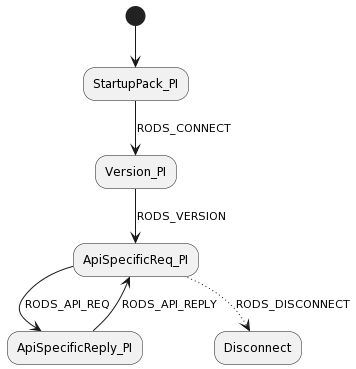

## Stat a Collection <a class="anchor" id="stat_coll"></a>
This step is necessary to make sure that the directory about to be ls'd actually exists.

First, we'll have to generate a `DataObjInp_PI`. This is a generic message type used for all sorts of operations. It also contains a `KeyValPair_PI`, which is an important data structure in the iRODS protocol. Although it cannot be sent on its own, it is a very important vehicle for parameters. Internally, this `KeyValPair_PI` is a cond_input structure.

In [ ]:
## #define DataObjInp_PI "str objPath[MAX_NAME_LEN]; int createMode; int openFlags; double offset; \
##  double dataSize; int numThreads; int oprType; struct *SpecColl_PI; struct KeyValPair_PI;"
def data_obj_inp(
    obj_path,
    create_mode="0",
    open_flags="0",
    offset="0",
    data_size="0",
    num_threads="0",
    opr_type="0",
    cond_input= {}
) -> bytes:
    obj_inp = ET.fromstring(f"""
    <DataObjInp_PI>
        <objPath>{obj_path}</objPath>
        <createMode>{create_mode}</createMode>
        <openFlags>{open_flags}</openFlags>
        <offset>{offset}</offset>
        <dataSize>{data_size}</dataSize>
        <numThreads>{num_threads}</numThreads>
        <oprType>{opr_type}</oprType>
    </DataObjInp_PI>
    """)
    ET.indent(obj_inp)
    obj_inp = append_kvp(obj_inp, cond_input)
    ret = ET.tostring(obj_inp).decode("utf-8").replace("\n", "").replace(" ", "").encode('utf-8')
    print(ret)
    return ret

Next, we'll need some utility methods. How these work might not be totally obvious, so consider reading ahead and revisiting these once you've seen how it's used in the stat API Call.

In [ ]:
def append_kvp(et, data):
    kvp = ET.Element("KeyValPair_PI")
    sslen = ET.Element("ssLen")
    sslen.text = str(len(data))
    kvp.append(sslen)
    for key in data.keys():
        keyWord = ET.Element("keyWord")
        keyWord.text = key
        kvp.append(keyWord)
    for value in data.values():
        svalue = ET.Element("svalue")
        svalue.text = value
        kvp.append(svalue)
    et.append(kvp)
    return et

def append_iivp(et, data):
    iivp = ET.Element("InxIvalPair_PI")
    sslen = ET.Element("iiLen")
    sslen.text = str(len(data))
    iivp.append(sslen)
    for key in data.keys():
        inx = ET.Element("inx")
        inx.text = key
        iivp.append(inx)
    for value in data.values():
        ivalue = ET.Element("ivalue")
        ivalue.text = value
        iivp.append(ivalue)
    et.append(iivp)
    return et

def append_ivp(et, data):
    ivp = ET.Element("InxValPair_PI")
    islen = ET.Element("isLen")
    islen.text = str(len(data))
    ivp.append(islen)
    for key in data.keys():
        inx = ET.Element("inx")
        inx.text = key
        ivp.append(inx)
    for value in data.values():
        svalue = ET.Element("svalue")
        svalue.text = value
        ivp.append(svalue)
    et.append(ivp)
    return et

In [ ]:

stat_obj_inp = data_obj_inp("/tempZone/home/rods") 
h = header(HeaderType.RODS_API_REQ.value, 
           stat_obj_inp, 
           int_info=API_TABLE["OBJ_STAT_AN"])

send_header(h, conn)
send_msg(stat_obj_inp, conn)

If everything has gone smoothely, you should receive a `RodsObjStat_PI` from the server. That `objType` is 2 tells us that the thing we stat'd was a collection. Since collections are purely virtual objects, `objSize` is 0.

In [ ]:
h, m = recv(conn)

# Querying for the Data Objects in a Container <a class="anchor" id="data_objects_query"></a>

Now we know our target is there. Let's go ahead and read its contents. This happens through a genQuery. For details about the first-generation GenQuery API, see [here](https://github.com/irods/irods_docs/blob/main/docs/developers/library_examples.md#querying-the-catalog-using-general-queries). For information about the GenQuery2 interface (under development as of time of writing), see [here](https://www.youtube.com/watch?v=3dR_JoGA6wA&t=654s&ab_channel=TheiRODSConsortium).

In [ ]:
## #define GenQueryInp_PI "int maxRows; int continueInx; int partialStartIndex; \
## int options; struct KeyValPair_PI; struct InxIvalPair_PI; struct InxValPair_PI;"
def gen_query(
    max_rows=256,
    continue_inx=0,
    partial_start_index=0,
    options=0,
    cond_input={},
    select_inp={},
    sql_cond_inp={}
) -> bytes:
    ret = ET.fromstring(f"""
    <GenQueryInp_PI>
        <maxRows>{max_rows}</maxRows>
        <continueInx>{continue_inx}</continueInx>
        <partialStartIndex>{partial_start_index}</partialStartIndex>
        <options>{options}</options>
    </GenQueryInp_PI>
    """)
    ret = append_kvp(ret, cond_input)
    ret = append_iivp(ret, select_inp)
    ret = append_ivp(ret, sql_cond_inp)
    
    return ET.tostring(ret).decode("utf-8").replace(" ", "").replace("\n", "").encode("utf-8")

## The Catalog ships with a table of SQL functions that can perform common functions
## The first link above also has an example of a specific query.
## Note that the server will send back a GenQueryOut_PI; there is no 
## message type dedicated to results from a specQuery. However, all the SqlResult_PIs
## will have `attriInx` set to 0, since knowing the query string allows the client to 
## reconstruct the order of the columns.
def spec_query(
    sql,
    arg_1,
    max_rows=256,
    continue_inx=0,
    row_offset=0,
    options=0,
    cond_input={}
) -> bytes:
    ret = ET.fromstring(f"""
    <specificQueryInp_PI>
        <sql>{sql}</sql>
        <arg1>{arg_1}</arg1>
        <maxRows>{max_rows}</maxRows>
        <continueInx>{continue_inx}</continueInx>
        <rowOffset>{row_offset}</rowOffset>
        <options>{options}</options>
    </specificQueryInp_PI>
    """)
    ret = append_kvp(ret, cond_input)
    
    return ET.tostring(ret)

In [ ]:
gq = gen_query(
    select_inp={
        CATALOG_INDEX_TABLE["COL_COLL_NAME"]    :"1",
        CATALOG_INDEX_TABLE["COL_DATA_NAME"]    :"1",
        CATALOG_INDEX_TABLE["COL_D_DATA_ID"]    :"1",
        CATALOG_INDEX_TABLE["COL_DATA_MODE"]    :"1",
        CATALOG_INDEX_TABLE["COL_DATA_SIZE"]    :"1",
        CATALOG_INDEX_TABLE["COL_D_MODIFY_TIME"]:"1",
        CATALOG_INDEX_TABLE["COL_D_CREATE_TIME"]:"1"
    },
    sql_cond_inp={
        CATALOG_INDEX_TABLE["COL_COLL_NAME"]    :f"= '/tempZone/home/{RODS_USER}'"
    }
)

*NB:* It might be easier to make sense of the server's response if you make sure the directory you're about to stat is populated.

One quick thing before we send this over to the server: the iRODS dialect of XML has a few quirks related to encoding special characters. Some special characters it does not escape at all. For others, it uses a non-standard encoding. For example, iRODS XML does not distinguish between "\`" and "'" (backticks and single quotes). For these reasons, we'll need to write some functions that translate between standard XML and iRODS XML.

In [ ]:
STANDARD_TO_IRODS_TABLE = {
  b'"'    :b"&quot;",
  b"&#34;":b"&quot;",
    
  b"&#39;":b"&apos;",
    
  b"&#x9;":b"\t",
    
  b"&#xD;":b"\r",
    
  b"&#xA;":b"\n",
    
  b"`"    :b"&apos;",
  b"'"    :b"&apos;"
}


def translate_xml_to_irods_dialect(xml_bytes):
    inc = 0
    for prefix in STANDARD_TO_IRODS_TABLE:
        xml_bytes = xml_bytes.replace(prefix, STANDARD_TO_IRODS_TABLE[prefix])
    return xml_bytes

gq = translate_xml_to_irods_dialect(gq)
print(gq)

h = header(HeaderType.RODS_API_REQ.value, 
           gq, 
           int_info=API_TABLE["GEN_QUERY_AN"])

In [ ]:
send_header(h, conn)
send_msg(gq, conn)

The results from this GenQuery might be a little hard to grok. 

In [ ]:
h, m = recv(conn)

To demonstrate how they amount to valid SQL results, let's translate these into a Pandas DataFrame. To see a similar example in C++ that operates above the protocol level, refer to the genQuery1 documentation linked above.

In [ ]:
def read_gen_query_results_into_dataframe(gqr):    
    ## Each SqlResult_PI is a column of data
    ## Collect them all into a list
    ## We can safely ignore the "reslen" attribute since the Python XML 
    ## API already knows how large each string is, but you might use it for error checking
    row_cnt = int(gqr.find("rowCnt").text)
    attribute_cnt = int(gqr.find("attriCnt").text)
    
    data = {}
    for result in gqr.findall("SqlResult_PI"):
        attri_inx = result.find("attriInx").text
        if attri_inx == "0":
            continue
        # res_len = int(result.find("reslen").text)
        values = result.findall("value")
        col = [value.text for value in values]
        data[CATALOG_REVERSE_INDEX_TABLE[attri_inx]] = col
            
    return pd.DataFrame(data)

read_gen_query_results_into_dataframe(m)

# Data Transfer <a class="anchor" id="data_transfer"></a>

Now that we can see the contents of this collection, let's create a new data object inside of it. 
This will show cases some of the more advanced features of `condInpt`. 

In [ ]:
## Suppose we want to transfer a file containing this text.
hello_cpp = """
#include <iostream>

int main() {
    std::cout << "Hello World!";
    return 0;
}
"""

In [ ]:
data_object_name = "hello.cpp"
data_size=str(len(hello_cpp.encode("utf-8")))
iput_payload = data_obj_inp(
    f"/tempZone/home/{RODS_USER}/{data_object_name}",
    open_flags="2",
    data_size=data_size,
    opr_type="1",
    cond_input={
        "dataType":"generic",
        "dataSize":data_size,
        "dataIncluded":" "    ## Generally, keys with empty values in cond_input act as flags
    }
)
h = header(HeaderType.RODS_API_REQ.value, 
           iput_payload, 
           int_info=API_TABLE["DATA_OBJ_PUT_AN"],
           bs_len=len(hello_cpp.encode("utf-8")))
send_header(h, conn)
send_msg(iput_payload, conn, bs_buf=hello_cpp.encode("utf-8"))

Once you've received the response from the server and verified that `intInfo` is zero, go re-run the genQuery which produced the ls you ran before. You should see new file there.

In [ ]:
h, m = recv(conn)

In [ ]:
h = header(HeaderType.RODS_API_REQ.value, 
           gq, 
           int_info=API_TABLE["GEN_QUERY_AN"])
gq = gen_query(
    select_inp={
        CATALOG_INDEX_TABLE["COL_COLL_NAME"]    :"1",
        CATALOG_INDEX_TABLE["COL_DATA_NAME"]    :"1",
        CATALOG_INDEX_TABLE["COL_D_DATA_ID"]    :"1",
        CATALOG_INDEX_TABLE["COL_DATA_MODE"]    :"1",
        CATALOG_INDEX_TABLE["COL_DATA_SIZE"]    :"1",
        CATALOG_INDEX_TABLE["COL_D_MODIFY_TIME"]:"1",
        CATALOG_INDEX_TABLE["COL_D_CREATE_TIME"]:"1"
    },
    sql_cond_inp={
        CATALOG_INDEX_TABLE["COL_COLL_NAME"]:"= '/tempZone/home/rods'"
    }
)
gq = translate_xml_to_irods_dialect(gq)
send_header(h, conn)
send_msg(gq, conn)
h, m = recv(conn)
read_gen_query_results_into_dataframe(m)

## Streaming <a class="anchor" id="data_transfer"></a>

Modern iRODS versions implement parallel transfer using multiple streams. This documentation won't implement parallel transfer, but will show how to use the streaming API that it is built on top of.

In [ ]:
## We'll open this file, seek past #includes and read. 
## Streamed putting works similarly, and in general
## you can think of these calls as analogous to their UNIX counterparts.
streaming_open_request = data_obj_inp(
    "/tempZone/home/rods/hello.cpp",
    open_flags="2",
    data_size="-1" ## We're getting the data from somewhere else,
                   ## so obviously we don't know how big it is
)
h = header(
    HeaderType.RODS_API_REQ.value,
    streaming_open_request,
    int_info=API_TABLE["DATA_OBJ_OPEN_AN"]
)
send_header(h, conn)
send_msg(streaming_open_request, conn)

In [ ]:
h, m = recv(conn)

In [ ]:
print(h.find("intInfo").text)

In [ ]:
## This time intInfo, if it is positive, will be the value of the L1 Descriptor return by the server,
## which is an opaque handle to a replica of the data object we just opened.
## Notice that it's 3, just like you'd expect opening the first file on a UNIX system.
l1_descriptor = h.find("intInfo").text
seek_len = 22

## These constants are taken from their Linux equivalents
## and work the same way
SEEK_SET = 0
SEEK_CUR = 1
SEEK_END = 2

## #define OpenedDataObjInp_PI "int l1descInx; int len; int whence; int oprType; \
## double offset; double bytesWritten; struct KeyValPair_PI;"
def opened_data_obj_inp(l1_desc,
                       len_=0,
                       whence=SEEK_SET,
                       opr_type=0,
                       offset=0,
                       bytes_written=0,
                       cond_input={}):
    ret = ET.fromstring(f"""
    <OpenedDataObjInp_PI>
        <l1descInx>{l1_desc}</l1descInx>
        <len>{len_}</len>
        <whence>{whence}</whence>
        <oprType>{opr_type}</oprType>
        <offset>{offset}</offset>
        <bytesWritten>{bytes_written}</bytesWritten>
    </OpenedDataObjInp_PI>
    """)
    
    ret = append_kvp(ret, cond_input)
    return ET.tostring(ret).decode("utf-8").replace(" ", "").replace("\n", "").encode("utf-8")

In [ ]:
seeker = opened_data_obj_inp(l1_descriptor, offset=seek_len)
print(seeker)
h = header(
    HeaderType.RODS_API_REQ.value,
    seeker,
    int_info=API_TABLE["DATA_OBJ_LSEEK_AN"]
)
send_header(h, conn)
send_msg(seeker, conn)

In [ ]:
h, m = recv(conn)

In [ ]:
reader = opened_data_obj_inp(l1_descriptor, len_=8192) ## The len parameter is important -- 
                                                       ## this tells the server how many 
                                                       ## bytes to stream back to the client
print(reader)
h = header(
    HeaderType.RODS_API_REQ.value,
    reader, 
    int_info=API_TABLE["DATA_OBJ_READ_AN"]
)
send_header(h, conn)
send_msg(reader, conn)

In [ ]:
h, m = recv(conn)

In [ ]:
closer = opened_data_obj_inp(l1_descriptor)
h = header(
    HeaderType.RODS_API_REQ.value,
    closer,
    int_info=API_TABLE["DATA_OBJ_CLOSE_AN"]
)

In [ ]:
send_header(h, conn)
send_msg(closer, conn)

In [ ]:
h, m = recv(conn)

# Admin <a class="anchor" id="admin"></a>
Next, we're going to look at how to perform admin tasks. Recall from the section where we implemented "ils" that the iRODS server ships with prebuilt queries stored in the catalog. These are called "specific queries." The iCommand `asq` allows administrators to add new catalog queries. Let's implement `asq` straight from the protocol.

You might notice that the parameters for `generalAdminInp_PI` are not very self-describing. To get a better sense of what you can do with the admin API and how to map those to arguments, see [`server/api/src/rsGeneralAdmin.cpp`](https://github.com/irods/irods/blob/main/server/api/src/rsGeneralAdmin.cpp), and specifically the function `_rsGeneralAdmin`.

In [ ]:
dummy_spec_query = "SELECT data_name FROM r_data_main"

## #define generalAdminInp_PI "str *arg0; str *arg1; str *arg2; \
## str *arg3; str *arg4; str *arg5; str *arg6; str *arg7;  str *arg8;  str *arg9;"
def general_admin_inp(
    arg_zero=" ",
    arg_one=" ",
    arg_two=" ",
    arg_three=" ",
    arg_four=" ",
    arg_five=" ",
    arg_six=" ",
    arg_seven=" ",
    arg_eight=" ",
    arg_nine=" "
):
    return f"""
    <generalAdminInp_PI>
        <arg0>{arg_zero}</arg0>
        <arg1>{arg_one}</arg1>
        <arg2>{arg_two}</arg2>
        <arg3>{arg_three}</arg3>
        <arg4>{arg_four}</arg4>
        <arg5>{arg_five}</arg5>
        <arg6>{arg_six}</arg6>
        <arg7>{arg_seven}</arg7>
        <arg8>{arg_eight}</arg8>
        <arg9>{arg_nine}</arg9>
    </generalAdminInp_PI>
    """.replace("\n", "").encode("utf-8")

In [ ]:
new_spec_query_req = general_admin_inp(
    arg_zero="add",
    arg_one="specificQuery",
    arg_two=dummy_spec_query,
    arg_three="another_dummy_spec_query"
)
h = header(
    HeaderType.RODS_API_REQ.value,
    new_spec_query_req,
    int_info=API_TABLE["GENERAL_ADMIN_AN"]
)

In [48]:
send_header(h, conn)
send_msg(new_spec_query_req, conn)

[header_len] - [b'\x00\x00\x00\x86']
[header] - [b'<MsgHeader_PI><type>RODS_API_REQ</type><msgLen>342</msgLen><errorLen>0</errorLen><bsLen>0</bsLen><intInfo>701</intInfo></MsgHeader_PI>']
[msg] - [b'    <generalAdminInp_PI>        <arg0>add</arg0>        <arg1>specificQuery</arg1>        <arg2>SELECT data_name FROM r_data_main</arg2>        <arg3>another_dummy_spec_query</arg3>        <arg4> </arg4>        <arg5> </arg5>        <arg6> </arg6>        <arg7> </arg7>        <arg8> </arg8>        <arg9> </arg9>    </generalAdminInp_PI>    ']


In [49]:
h, m = recv(conn) ## Assuming int_info is 0, you should now be able to run your query on the command line like this:
                  ## "iquest --no-page --sql dummy_spec_query"

HEADER LEN: [147]
<MsgHeader_PI>
  <type>RODS_API_REPLY</type>
  <msgLen>0</msgLen>
  <errorLen>119</errorLen>
  <bsLen>0</bsLen>
  <intInfo>-816000</intInfo>
</MsgHeader_PI>
[recv] getting error stack
b'<RError_PI>\n<count>1</count>\n<RErrMsg_PI>\n<status>0</status>\n<msg>Alias is not unique</msg>\n</RErrMsg_PI>\n</RError_PI>\n'


# Rule Exec <a class="anchor" id="rule_exec"></a>
The last thing we'll look at is sending rule execution requests.
We won't procedurally create this string to reduce complexity, but the structure of these XML structures should be clear from the context. The text of this rule is taken from [documentation](https://vlaams-supercomputing-centrum-vscdocumentation.readthedocs-hosted.com/en/latest/data/workflow_automation.html) produced by the Vlaams Supercomputing Center.

In [59]:
rule_text = """
veryAdvancedHelloWorldRule{
    writeLine("stdout","$userNameClient says '*greeting1 *greeting2'")
}
"""

## #define ExecMyRuleInp_PI "str myRule[META_STR_LEN]; struct RHostAddr_PI; \
## struct KeyValPair_PI; str outParamDesc[LONG_NAME_LEN]; struct *MsParamArray_PI;"
rule_exec_PI = ET.fromstring(f"""
<ExecMyRuleInp_PI>
<myRule>@external
veryAdvancedHelloWorldRule{{
    writeLine('stdout',"$userNameClient says '*greeting1 *greeting2'")
}}
</myRule>
<RHostAddr_PI>
<hostAddr></hostAddr>
<rodsZone></rodsZone>
<port>0</port>
<dummyInt>0</dummyInt>
</RHostAddr_PI>
<KeyValPair_PI>
<ssLen>1</ssLen>
<keyWord>instance_name</keyWord>
<svalue>irods_rule_engine_plugin-irods_rule_language-instance</svalue>
</KeyValPair_PI>
<outParamDesc>ruleExecOut</outParamDesc>
<MsParamArray_PI>
<paramLen>2</paramLen>
<oprType>0</oprType>
<MsParam_PI>
<label>*greeting1</label>
<type>STR_PI</type>
<STR_PI>
<myStr> 'Hello'</myStr>
</STR_PI>
</MsParam_PI>
<MsParam_PI>
<label>*greeting2</label>
<type>STR_PI</type>
<STR_PI>
<myStr> 'World'</myStr>
</STR_PI>
</MsParam_PI>
</MsParamArray_PI>
</ExecMyRuleInp_PI>
""".encode("utf-8"))
rule_exec_PI = ET.tostring(rule_exec_PI)
rule_exec_PI = translate_xml_to_irods_dialect(rule_exec_PI)
print(rule_exec_PI)

b'<ExecMyRuleInp_PI>\n<myRule>@external\nveryAdvancedHelloWorldRule{\n    writeLine(&apos;stdout&apos;,&quot;$userNameClient says &apos;*greeting1 *greeting2&apos;&quot;)\n}\n</myRule>\n<RHostAddr_PI>\n<hostAddr />\n<rodsZone />\n<port>0</port>\n<dummyInt>0</dummyInt>\n</RHostAddr_PI>\n<KeyValPair_PI>\n<ssLen>1</ssLen>\n<keyWord>instance_name</keyWord>\n<svalue>irods_rule_engine_plugin-irods_rule_language-instance</svalue>\n</KeyValPair_PI>\n<outParamDesc>ruleExecOut</outParamDesc>\n<MsParamArray_PI>\n<paramLen>2</paramLen>\n<oprType>0</oprType>\n<MsParam_PI>\n<label>*greeting1</label>\n<type>STR_PI</type>\n<STR_PI>\n<myStr> &apos;Hello&apos;</myStr>\n</STR_PI>\n</MsParam_PI>\n<MsParam_PI>\n<label>*greeting2</label>\n<type>STR_PI</type>\n<STR_PI>\n<myStr> &apos;World&apos;</myStr>\n</STR_PI>\n</MsParam_PI>\n</MsParamArray_PI>\n</ExecMyRuleInp_PI>'


In [60]:
h = header(
    HeaderType.RODS_API_REQ.value,
    rule_exec_PI,
    int_info=API_TABLE["EXEC_MY_RULE_AN"]
)
send_header(h, conn)
send_msg(rule_exec_PI, conn)

[header_len] - [b'\x00\x00\x00\x86']
[header] - [b'<MsgHeader_PI><type>RODS_API_REQ</type><msgLen>820</msgLen><errorLen>0</errorLen><bsLen>0</bsLen><intInfo>625</intInfo></MsgHeader_PI>']
[msg] - [b'<ExecMyRuleInp_PI>\n<myRule>@external\nveryAdvancedHelloWorldRule{\n    writeLine(&apos;stdout&apos;,&quot;$userNameClient says &apos;*greeting1 *greeting2&apos;&quot;)\n}\n</myRule>\n<RHostAddr_PI>\n<hostAddr />\n<rodsZone />\n<port>0</port>\n<dummyInt>0</dummyInt>\n</RHostAddr_PI>\n<KeyValPair_PI>\n<ssLen>1</ssLen>\n<keyWord>instance_name</keyWord>\n<svalue>irods_rule_engine_plugin-irods_rule_language-instance</svalue>\n</KeyValPair_PI>\n<outParamDesc>ruleExecOut</outParamDesc>\n<MsParamArray_PI>\n<paramLen>2</paramLen>\n<oprType>0</oprType>\n<MsParam_PI>\n<label>*greeting1</label>\n<type>STR_PI</type>\n<STR_PI>\n<myStr> &apos;Hello&apos;</myStr>\n</STR_PI>\n</MsParam_PI>\n<MsParam_PI>\n<label>*greeting2</label>\n<type>STR_PI</type>\n<STR_PI>\n<myStr> &apos;World&apos;</myStr>\n</STR_PI>\

This rule prints "Hello World!" to stdout. Notice that when you receive that message from the server, the buffer is 5464 bytes long and contains a long string of null/garbage characters after the desired string. This is a known feature of the native rule engine; when printing to stdout, it always allocates a buffer of this size and assumes that the client will look for a null-terminator to determine to where the actual content is.

In [61]:
h, m = recv(conn)

HEADER LEN: [142]
<MsgHeader_PI>
  <type>RODS_API_REPLY</type>
  <msgLen>7625</msgLen>
  <errorLen>0</errorLen>
  <bsLen>0</bsLen>
  <intInfo>0</intInfo>
</MsgHeader_PI>
<MsParamArray_PI>
  <paramLen>1</paramLen>
  <oprType>0</oprType>
  <MsParam_PI>
    <label>ruleExecOut</label>
    <type>ExecCmdOut_PI</type>
    <ExecCmdOut_PI>
      <BinBytesBuf_PI>
        <buflen>5464</buflen>
        <buf>cm9kcyBzYXlzICdIZWxsbyBXb3JsZCcKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

# Changing Your Password <a class="anchor" id="ipasswd"></a>
In addition to the general admin capabilities, iRODS exposes certain administrative abilities to rodsusers. First, we'll create a new user. This step just involves switching parameters in `generalAdminInp_PI`, so you might want to skip if you're not interested in that. However, switching 

In [53]:
def user_admin(
    arg_zero=" ",
    arg_one=" ",
    arg_two=" ",
    arg_three=" ",
    arg_four=" ",
    arg_five=" ",
    arg_six=" ",
    arg_seven=" ",
    arg_eight=" ",
    arg_nine=" "
):
    return f"""
    <userAdminInp_PI>
        <arg0>{arg_zero}</arg0>
        <arg1>{arg_one}</arg1>
        <arg2>{arg_two}</arg2>
        <arg3>{arg_three}</arg3>
        <arg4>{arg_four}</arg4>
        <arg5>{arg_five}</arg5>
        <arg6>{arg_six}</arg6>
        <arg7>{arg_seven}</arg7>
        <arg8>{arg_eight}</arg8>
        <arg9>{arg_nine}</arg9>
    </userAdminInp_PI>
    """.replace("\n", "").replace(" ", "").encode("utf-8")

In [54]:
obfuscated_password = obf.obfuscate_new_password("testpass",
                                                PASSWORD,
                                                signature)

pw_change_request = user_admin(
    arg_zero="userpw",
    arg_one=RODS_USER,
    arg_two="password",
    arg_three=obfuscated_password
)

In [55]:
h = header(
    HeaderType.RODS_API_REQ.value,
    pw_change_request,
    int_info=API_TABLE["USER_ADMIN_AN"]
)
send_header(h, conn)
send_msg(pw_change_request, conn)

[header_len] - [b'\x00\x00\x00\x86']
[header] - [b'<MsgHeader_PI><type>RODS_API_REQ</type><msgLen>230</msgLen><errorLen>0</errorLen><bsLen>0</bsLen><intInfo>714</intInfo></MsgHeader_PI>']
[msg] - [b'<userAdminInp_PI><arg0>userpw</arg0><arg1>rods</arg1><arg2>password</arg2><arg3>UE7hJUG\'AX)nB9D,d1Z,7IQ"kg6a02sCcL!mLfDv6ta%B5M</arg3><arg4></arg4><arg5></arg5><arg6></arg6><arg7></arg7><arg8></arg8><arg9></arg9></userAdminInp_PI>']


In [56]:
h, m = recv(conn)

HEADER LEN: [145]
<MsgHeader_PI>
  <type>RODS_API_REPLY</type>
  <msgLen>0</msgLen>
  <errorLen>0</errorLen>
  <bsLen>0</bsLen>
  <intInfo>-903000</intInfo>
</MsgHeader_PI>


# Disconnect <a class="anchor" id="disconnect"></a>
Finally, we'll disconnect from the iRODS server.

In [57]:
def disconnect(sock):
    sock.send(
        header(HeaderType.RODS_DISCONNECT.value, "") ## Empty string so msgLen is 0
    )

In [58]:
disconnect(conn)
conn.close()

# Appendix: iRODS Protocol Gotchas <a class="anchor" id="gotchas"></a>

- Forgetting to close a tag can often trip up the server's parsing logic in such a way that it sends a header with `intInfo` 0, or some other indication that the request was successful. However, the next message will have an error code `-15000` indicating a formatting error. A similar behavior is sometimes
seen if a call to `recv` (or whatever function you write that pulls bytes out of the TCP socket) is left out after an API request.
- Although the protocol is supposed to be white-space agnostic, sometimes beginning a message with a newline character (`\n`) can cause unexpected behavior. Caution is best in this situation.
- The protocol is order-dependent; that is, the order in which XML elements appear in the messages must be exactly identical to the order in which they appear in the corresponding packing instruction string as defined in `rodsPackInstruct.h`